In [1]:
import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason
import vertexai.preview.generative_models as generative_models
from google.oauth2 import service_account
from io import BytesIO
from PIL import Image

credentials = service_account.Credentials.from_service_account_file(filename=r"file.json", scopes=['https://www.googleapis.com/auth/cloud-platform'])

def image_to_base64(image_path):
    with Image.open(image_path) as img:
        buffered = BytesIO()
        img.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str

def generate():
  vertexai.init(project="P_name", location="",credentials=credentials)
  model = GenerativeModel(
    "gemini-1.5",
  )
  responses = model.generate_content(
      ["""Process the image properly ,very clearly and detect correctly  exact results whether the image consist of 'fire,' 'smoke,' or 'fire+smoke'. Return only the detected keyword (fire, smoke, or fire+smoke) along with the confidence score and the bounding box coordinates indicating the region of the image where the abnormality is located""", image1],
      generation_config=generation_config,
      safety_settings=safety_settings,
      stream=True,
  )

  for response in responses:
    print(response.text, end="")

base64_str = image_to_base64(r"C:\Users\pkathi\Desktop\my work\object detection\fire\train\images\54.xmaseve2_1545640297.jpg")

image1 = Part.from_data(
    mime_type="image/png",
    data=base64.b64decode(base64_str)
)

generation_config = {
    "max_output_tokens": 8192,
    "temperature": 1,
    "top_p": 0.95,
}

safety_settings = {
    generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
}


generate()


fire+smoke, 0.9999400353431702, 362,290,517,622 


In [17]:
import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part
from google.oauth2 import service_account
from io import BytesIO
from PIL import Image
import os
import shutil
import cv2
import numpy as np
from multiprocessing.pool import ThreadPool

# Initialize Vertex AI with credentials
credentials = service_account.Credentials.from_service_account_file(
    filename=r".json",#credentials json file
    scopes=['']#linkfor cloud platform
)

def image_to_base64(image_path):
    with Image.open(image_path) as img:
        buffered = BytesIO()
        img.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str

def classify_image(image_base64):
    vertexai.init(project="", location="us-central1", credentials=credentials)
    model = GenerativeModel("gemini-1.5-flash-001") #model name

    image_part = Part.from_data(
        mime_type="image/png",
        data=base64.b64decode(image_base64)
    )

    prompt = """Process the image to detect the presence of 'fire,' 'smoke,' or 'fire+smoke'. 
    Return only the detected keyword (fire, smoke, or fire+smoke) along with the confidence score and the bounding box coordinates indicating the region of the image where the abnormality is located."""

    responses = model.generate_content(
        [prompt, image_part],
        generation_config={
            "max_output_tokens": 8192,
            "temperature": 1,
            "top_p": 0.95,
        },
        safety_settings={},
        stream=True,
    )

    result = ""
    for response in responses:
        result += response.text

    return result.strip()

def process_frame(frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir, abnormality_group_id):
    frame_resized = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)
    frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
    frame_diff = cv2.absdiff(prev_frame_gray, frame_gray)
    _, thresh = cv2.threshold(frame_diff, threshold_value, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected = any(cv2.contourArea(contour) > min_contour_area for contour in contours)
    if detected:
        output_frame_path = os.path.join(output_dir, f"abnormality_{abnormality_group_id}", f"frame_{frame_number}.jpg")
        cv2.imwrite(output_frame_path, frame_resized)
    
    return detected, frame_gray

def motion_detection(video_path, output_dir, threshold_value=25, min_contour_area=500, resize_factor=0.5, minimal_fps=5, min_abnormality_gap_minutes=1):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file")
        return

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_skip_interval = int(round(original_fps / minimal_fps))

    ret, prev_frame = cap.read()
    if not ret:
        print("Error reading the first frame")
        return

    prev_frame = cv2.resize(prev_frame, (0, 0), fx=resize_factor, fy=resize_factor)
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    abnormality_times = []

    frame_number = 0
    abnormality_detected = False
    abnormality_start_frame = None
    abnormality_group_id = 0
    last_abnormality_time = None

    os.makedirs(output_dir, exist_ok=True)

    pool = ThreadPool(processes=4)  # Use a thread pool with 4 threads

    while True:
        for _ in range(frame_skip_interval):
            ret = cap.grab()  # Use grab to skip frames efficiently
            if not ret:
                break
            frame_number += 1

        if not ret:
            break

        ret, frame = cap.retrieve()  # Retrieve the frame after skipping
        if not ret:
            break

        # Use thread pool to process frame
        result = pool.apply_async(process_frame, (frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir, abnormality_group_id))
        detected, prev_frame_gray = result.get()

        if detected:
            current_abnormality_time = frame_number / original_fps

            if not abnormality_detected:
                if last_abnormality_time is None or (current_abnormality_time - last_abnormality_time) >= (min_abnormality_gap_minutes * 60):
                    abnormality_group_id += 1
                    os.makedirs(os.path.join(output_dir, f"abnormality_{abnormality_group_id}"))

                abnormality_start_frame = frame_number
                abnormality_detected = True
                abnormality_times.append(frame_number)
                last_abnormality_time = current_abnormality_time

        else:
            if abnormality_detected:
                abnormality_detected = False
                abnormality_end_frame = frame_number
                abnormality_start_seconds = abnormality_start_frame / original_fps
                abnormality_end_seconds = abnormality_end_frame / original_fps
                abnormality_duration_seconds = abnormality_end_seconds - abnormality_start_seconds

                print(f"Abnormality {abnormality_group_id} start time: {int(abnormality_start_seconds // 60)} minutes {abnormality_start_seconds % 60:.2f} seconds")
                print(f"Abnormality {abnormality_group_id} duration: {int(abnormality_duration_seconds // 60)} minutes {abnormality_duration_seconds % 60:.2f} seconds")

    cap.release()
    pool.close()
    pool.join()

    total_time_seconds = frame_number / original_fps
    print(f"Total video time: {int(total_time_seconds // 60)} minutes {total_time_seconds % 60:.2f} seconds")

    return abnormality_times

def classify_and_store_images(output_dir):
    fire_dir = os.path.join(output_dir, 'fire')
    smoke_dir = os.path.join(output_dir, 'smoke')
    fire_smoke_dir = os.path.join(output_dir, 'fire+smoke')

    os.makedirs(fire_dir, exist_ok=True)
    os.makedirs(smoke_dir, exist_ok=True)
    os.makedirs(fire_smoke_dir, exist_ok=True)

    for folder_name in os.listdir(output_dir):
        folder_path = os.path.join(output_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue
        
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            base64_str = image_to_base64(image_path)
            classification_result = classify_image(base64_str)
            
            target_folder = None
            if "fire" in classification_result.lower():
                target_folder = fire_dir
            elif "smoke" in classification_result.lower():
                target_folder = smoke_dir
            elif "fire+smoke" in classification_result.lower():
                target_folder = fire_smoke_dir

            if target_folder:
                new_image_path = os.path.join(target_folder, image_file)
                shutil.move(image_path, new_image_path)
                print(f"Image {image_file} classified as {classification_result} and moved to {target_folder}")

# Example usage
video_path = r"C:\Users\pkathi\Desktop\my work\computervision-video\output48.mp4"
output_dir = 'C:/Users/pkathi/Desktop/my work/computervision-video/traiGeminiOP48-2.2'
abnormality_times = motion_detection(video_path, output_dir, minimal_fps=5)

if abnormality_times:
    print("Abnormality detected at frame numbers:", abnormality_times)
    classify_and_store_images(output_dir)
else:
    print("No abnormality detected in the video.")


Abnormality 1 start time: 0 minutes 45.00 seconds
Abnormality 1 duration: 0 minutes 12.00 seconds
Abnormality 1 start time: 0 minutes 57.40 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 0 minutes 57.80 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 0 minutes 58.20 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Total video time: 0 minutes 60.00 seconds
Abnormality detected at frame numbers: [1350, 1722, 1734, 1746, 1758]
Image frame_1356.jpg classified as ```json
{
 "keyword": "fire+smoke",
 "confidence": 0.8622325,
 "bbox": [
  256,
  418,
  461,
  793
 ]
}
``` and moved to C:/Users/pkathi/Desktop/my work/computervision-video/traiGeminiOP48-2.2\fire
Image frame_1362.jpg classified as ```json
{
 "keyword": "smoke",
 "confidence_score": 0.99,
 "bounding_box": {
  "x": 176,
  "y": 770,
  "width": 266,
  "height": 127
 }
}
``` and moved to C:/Users/pkathi/Desktop/my work/computervision-video/traiGeminiOP48-2.2\smo

In [18]:
import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part
from google.oauth2 import service_account
from io import BytesIO
from PIL import Image
import os
import shutil
import cv2
import numpy as np
from multiprocessing.pool import ThreadPool

# Initialize Vertex AI with credentials
credentials = service_account.Credentials.from_service_account_file(
    filename=r".json",
    scopes=['']
)

def image_to_base64(image_path):
    with Image.open(image_path) as img:
        buffered = BytesIO()
        img.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str

def classify_image(image_base64):
    vertexai.init(project=" ", location="us", credentials=credentials)
    model = GenerativeModel("gemini")

    image_part = Part.from_data(
        mime_type="image/png",
        data=base64.b64decode(image_base64)
    )

    prompt = """Process the image to detect the presence of 'fire,' 'smoke,' or 'fire+smoke'. 
    Return only the detected keyword (fire, smoke, or fire+smoke) along with the confidence score and the bounding box coordinates indicating the region of the image where the abnormality is located."""

    responses = model.generate_content(
        [prompt, image_part],
        generation_config={
            "max_output_tokens": 8192,
            "temperature": 1,
            "top_p": 0.95,
        },
        safety_settings={},
        stream=True,
    )

    result = ""
    for response in responses:
        result += response.text

    return result.strip().lower()

def process_frame(frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir, abnormality_group_id):
    frame_resized = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)
    frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
    frame_diff = cv2.absdiff(prev_frame_gray, frame_gray)
    _, thresh = cv2.threshold(frame_diff, threshold_value, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected = any(cv2.contourArea(contour) > min_contour_area for contour in contours)
    if detected:
        output_frame_path = os.path.join(output_dir, f"abnormality_{abnormality_group_id}", f"frame_{frame_number}.jpg")
        cv2.imwrite(output_frame_path, frame_resized)
    
    return detected, frame_gray

def motion_detection(video_path, output_dir, threshold_value=25, min_contour_area=500, resize_factor=0.5, minimal_fps=5, min_abnormality_gap_minutes=1):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file")
        return

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_skip_interval = int(round(original_fps / minimal_fps))

    ret, prev_frame = cap.read()
    if not ret:
        print("Error reading the first frame")
        return

    prev_frame = cv2.resize(prev_frame, (0, 0), fx=resize_factor, fy=resize_factor)
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    abnormality_times = []

    frame_number = 0
    abnormality_detected = False
    abnormality_start_frame = None
    abnormality_group_id = 0
    last_abnormality_time = None

    os.makedirs(output_dir, exist_ok=True)

    pool = ThreadPool(processes=4)  # Use a thread pool with 4 threads

    while True:
        for _ in range(frame_skip_interval):
            ret = cap.grab()  # Use grab to skip frames efficiently
            if not ret:
                break
            frame_number += 1

        if not ret:
            break

        ret, frame = cap.retrieve()  # Retrieve the frame after skipping
        if not ret:
            break

        # Use thread pool to process frame
        result = pool.apply_async(process_frame, (frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir, abnormality_group_id))
        detected, prev_frame_gray = result.get()

        if detected:
            current_abnormality_time = frame_number / original_fps

            if not abnormality_detected:
                if last_abnormality_time is None or (current_abnormality_time - last_abnormality_time) >= (min_abnormality_gap_minutes * 60):
                    abnormality_group_id += 1
                    os.makedirs(os.path.join(output_dir, f"abnormality_{abnormality_group_id}"))

                abnormality_start_frame = frame_number
                abnormality_detected = True
                abnormality_times.append(frame_number)
                last_abnormality_time = current_abnormality_time

        else:
            if abnormality_detected:
                abnormality_detected = False
                abnormality_end_frame = frame_number
                abnormality_start_seconds = abnormality_start_frame / original_fps
                abnormality_end_seconds = abnormality_end_frame / original_fps
                abnormality_duration_seconds = abnormality_end_seconds - abnormality_start_seconds

                print(f"Abnormality {abnormality_group_id} start time: {int(abnormality_start_seconds // 60)} minutes {abnormality_start_seconds % 60:.2f} seconds")
                print(f"Abnormality {abnormality_group_id} duration: {int(abnormality_duration_seconds // 60)} minutes {abnormality_duration_seconds % 60:.2f} seconds")

    cap.release()
    pool.close()
    pool.join()

    total_time_seconds = frame_number / original_fps
    print(f"Total video time: {int(total_time_seconds // 60)} minutes {total_time_seconds % 60:.2f} seconds")

    return abnormality_times

def classify_and_store_images(output_dir):
    fire_dir = os.path.join(output_dir, 'fire')
    smoke_dir = os.path.join(output_dir, 'smoke')
    fire_smoke_dir = os.path.join(output_dir, 'fire+smoke')

    os.makedirs(fire_dir, exist_ok=True)
    os.makedirs(smoke_dir, exist_ok=True)
    os.makedirs(fire_smoke_dir, exist_ok=True)

    for folder_name in os.listdir(output_dir):
        folder_path = os.path.join(output_dir, folder_name)
        if not os.path.isdir(folder_path) or 'abnormality_' not in folder_name:
            continue
        
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            base64_str = image_to_base64(image_path)
            classification_result = classify_image(base64_str)
            
            target_folder = None
            if "fire" in classification_result:
                if "smoke" in classification_result:
                    target_folder = fire_smoke_dir
                else:
                    target_folder = fire_dir
            elif "smoke" in classification_result:
                target_folder = smoke_dir

            if target_folder:
                new_image_path = os.path.join(target_folder, image_file)
                shutil.move(image_path, new_image_path)
                print(f"Image {image_file} classified as {classification_result} and moved to {target_folder}")

# Example usage
video_path = r"C:\Users\pkathi\Desktop\my work\computervision-video\output48.mp4"
output_dir = 'C:/Users/pkathi/Desktop/my work/computervision-video/traiGeminiOP48-2.3'
abnormality_times = motion_detection(video_path, output_dir, minimal_fps=5)

if abnormality_times:
    print("Abnormality detected at frame numbers:", abnormality_times)
    classify_and_store_images(output_dir)
else:
    print("No abnormality detected in the video.")


Abnormality 1 start time: 0 minutes 45.00 seconds
Abnormality 1 duration: 0 minutes 12.00 seconds
Abnormality 1 start time: 0 minutes 57.40 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 0 minutes 57.80 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 0 minutes 58.20 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Total video time: 0 minutes 60.00 seconds
Abnormality detected at frame numbers: [1350, 1722, 1734, 1746, 1758]
Image frame_1356.jpg classified as ```json
{
 "keyword": "fire",
 "confidence_score": 0.7285,
 "bounding_box": [
  389,
  538,
  467,
  581
 ]
}
``` and moved to C:/Users/pkathi/Desktop/my work/computervision-video/traiGeminiOP48-2.3\fire
Image frame_1362.jpg classified as smoke 0.9983271 194 783 822 and moved to C:/Users/pkathi/Desktop/my work/computervision-video/traiGeminiOP48-2.3\smoke
Image frame_1368.jpg classified as ```json
{
 "keyword": "smoke",
 "confidence_score": 0.9754405,
 "bbox":

In [19]:
import os
import shutil
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            images.append(filename)
    return images

def evaluate_classification(ground_truth_base, classified_base):
    ground_truth_folders = ['fire', 'smoke', 'fire+smoke']
    
    y_true = []
    y_pred = []

    for folder in ground_truth_folders:
        gt_folder = os.path.join(ground_truth_base, folder)
        classified_folder = os.path.join(classified_base, folder)

        gt_images = load_images_from_folder(gt_folder)
        classified_images = load_images_from_folder(classified_folder)

        # Ensure the lists are the same size for comparison
        gt_images_set = set(gt_images)
        classified_images_set = set(classified_images)
        
        # For precision and recall
        y_true.extend([folder] * len(gt_images_set))
        y_pred.extend([folder] * len(classified_images_set))
        
        # Add comparisons for false positives and false negatives
        false_positives = classified_images_set - gt_images_set
        false_negatives = gt_images_set - classified_images_set

        # Add false positives and false negatives to predictions
        for image in false_positives:
            y_true.append(folder)
            y_pred.append('unknown')  # 'unknown' for misclassified images
        
        for image in false_negatives:
            y_true.append(folder)
            y_pred.append('none')  # 'none' for missed images

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

# Define paths
ground_truth_base = r'C:\Users\pkathi\Desktop\my work\computervision-video\Evaluation'
classified_base = r"C:\Users\pkathi\Desktop\my work\computervision-video\traiGeminiOP48-2.3\Evaluation-classified"

evaluate_classification(ground_truth_base, classified_base)


Accuracy: 0.97
Precision: 1.00
Recall: 0.97
F1 Score: 0.98


In [21]:
import os
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def load_images_from_folder(folder):
    return set(filename for filename in os.listdir(folder) if os.path.isfile(os.path.join(folder, filename)))

def evaluate_classification(ground_truth_base, classified_base):
    categories = ['fire', 'smoke', 'fire+smoke']
    
    # Initialize lists to store ground truth and predictions
    y_true = []
    y_pred = []

    # Track false positives and false negatives
    false_positives = {category: set() for category in categories}
    false_negatives = {category: set() for category in categories}

    for category in categories:
        gt_folder = os.path.join(ground_truth_base, category)
        classified_folder = os.path.join(classified_base, category)

        gt_images = load_images_from_folder(gt_folder)
        classified_images = load_images_from_folder(classified_folder)

        # Compare classified images to ground truth
        for image in classified_images:
            if image in gt_images:
                y_true.append(category)
                y_pred.append(category)
            else:
                y_true.append('none')
                y_pred.append(category)
                false_positives[category].add(image)
        
        # Find false negatives
        for image in gt_images:
            if image not in classified_images:
                y_true.append(category)
                y_pred.append('none')
                false_negatives[category].add(image)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=categories + ['none'], average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)

    print(f"Overall Accuracy: {accuracy:.2f}")
    
    for i, category in enumerate(categories):
        print(f"\nCategory: {category}")
        print(f"Precision: {precision[i]:.2f}")
        print(f"Recall: {recall[i]:.2f}")
        print(f"F1 Score: {f1[i]:.2f}")
        print(f"False Positives: {len(false_positives[category])}")
        print(f"False Negatives: {len(false_negatives[category])}")

# Define paths
ground_truth_base = r'C:\Users\pkathi\Desktop\my work\computervision-video\Evaluation'
classified_base = r"C:\Users\pkathi\Desktop\my work\computervision-video\traiGeminiOP48-2.3\Evaluation-classified"

evaluate_classification(ground_truth_base, classified_base)

Overall Accuracy: 0.97

Category: fire
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
False Positives: 1
False Negatives: 0

Category: smoke
Precision: 1.00
Recall: 0.67
F1 Score: 0.80
False Positives: 0
False Negatives: 1

Category: fire+smoke
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
False Positives: 0
False Negatives: 0


In [23]:
import os
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import numpy as np

def load_images_from_folder(folder):
    return set(filename for filename in os.listdir(folder) if os.path.isfile(os.path.join(folder, filename)))

def evaluate_classification(ground_truth_base, classified_base):
    categories = ['fire', 'smoke', 'fire+smoke']
    
    # Initialize lists to store ground truth and predictions
    y_true = []
    y_pred = []

    # Track false positives and false negatives
    false_positives = {category: set() for category in categories}
    false_negatives = {category: set() for category in categories}

    for category in categories:
        gt_folder = os.path.join(ground_truth_base, category)
        classified_folder = os.path.join(classified_base, category)

        gt_images = load_images_from_folder(gt_folder)
        classified_images = load_images_from_folder(classified_folder)

        # Compare classified images to ground truth
        for image in classified_images:
            if image in gt_images:
                y_true.append(category)
                y_pred.append(category)
            else:
                y_true.append('none')
                y_pred.append(category)
                false_positives[category].add(image)
        
        # Find false negatives
        for image in gt_images:
            if image not in classified_images:
                y_true.append(category)
                y_pred.append('none')
                false_negatives[category].add(image)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=categories + ['none'], average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=categories + ['none'])

    print(f"Overall Accuracy: {accuracy:.2f}")
    
    for i, category in enumerate(categories):
        print(f"\nCategory: {category}")
        print(f"Precision: {precision[i]:.2f}")
        print(f"Recall: {recall[i]:.2f}")
        print(f"F1 Score: {f1[i]:.2f}")
        print(f"False Positives: {len(false_positives[category])}")
        print(f"False Negatives: {len(false_negatives[category])}")
    
    print("\nConfusion Matrix:")
    print("Rows represent the true categories, columns represent the predicted categories.")
    print(np.array(categories + ['none']))
    print(conf_matrix)

# Define paths
ground_truth_base = r'C:\Users\pkathi\Desktop\my work\computervision-video\Evaluation'
classified_base = r"C:\Users\pkathi\Desktop\my work\computervision-video\traiGeminiOP48-2.3\Evaluation-classified"

evaluate_classification(ground_truth_base, classified_base)


Overall Accuracy: 0.97

Category: fire
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
False Positives: 1
False Negatives: 0

Category: smoke
Precision: 1.00
Recall: 0.67
F1 Score: 0.80
False Positives: 0
False Negatives: 1

Category: fire+smoke
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
False Positives: 0
False Negatives: 0

Confusion Matrix:
Rows represent the true categories, columns represent the predicted categories.
['fire' 'smoke' 'fire+smoke' 'none']
[[ 0  0  0  0]
 [ 0  2  0  1]
 [ 0  0 67  0]
 [ 1  0  0  0]]


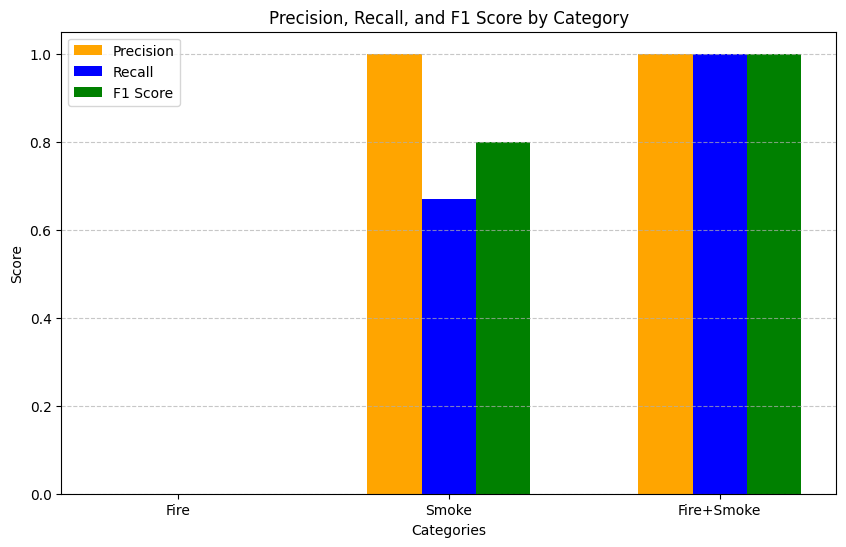

In [25]:
categories = ['Fire', 'Smoke', 'Fire+Smoke']
precision = [0.00, 1.00, 1.00]
recall = [0.00, 0.67, 1.00]
f1_score = [0.00, 0.80, 1.00]

x = range(len(categories))

plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=0.2, label='Precision', color='orange', align='center')
plt.bar([p + 0.2 for p in x], recall, width=0.2, label='Recall', color='blue', align='center')
plt.bar([p + 0.4 for p in x], f1_score, width=0.2, label='F1 Score', color='green', align='center')

plt.xlabel('Categories')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score by Category')
plt.xticks([p + 0.2 for p in x], categories)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

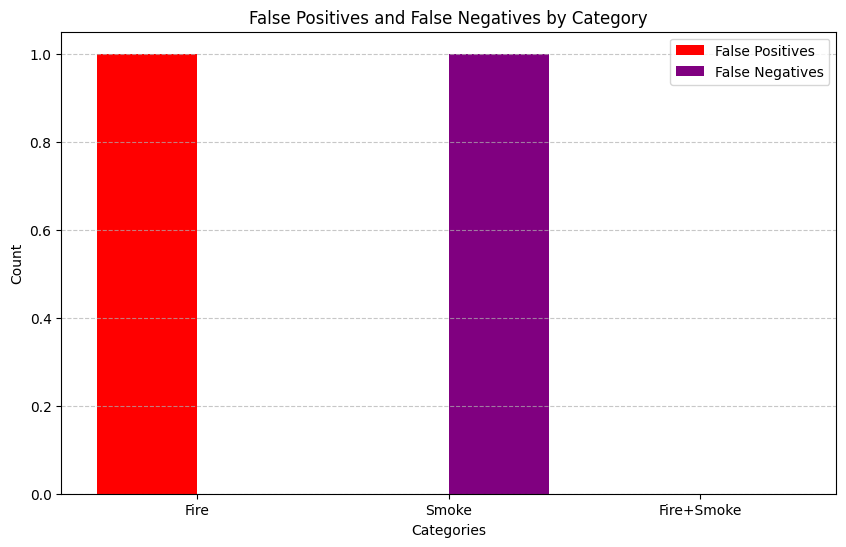

In [26]:
false_positives = [1, 0, 0]
false_negatives = [0, 1, 0]

plt.figure(figsize=(10, 6))
x = range(len(categories))

plt.bar(x, false_positives, width=0.4, label='False Positives', color='red', align='center')
plt.bar([p + 0.4 for p in x], false_negatives, width=0.4, label='False Negatives', color='purple', align='center')

plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('False Positives and False Negatives by Category')
plt.xticks([p + 0.2 for p in x], categories)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

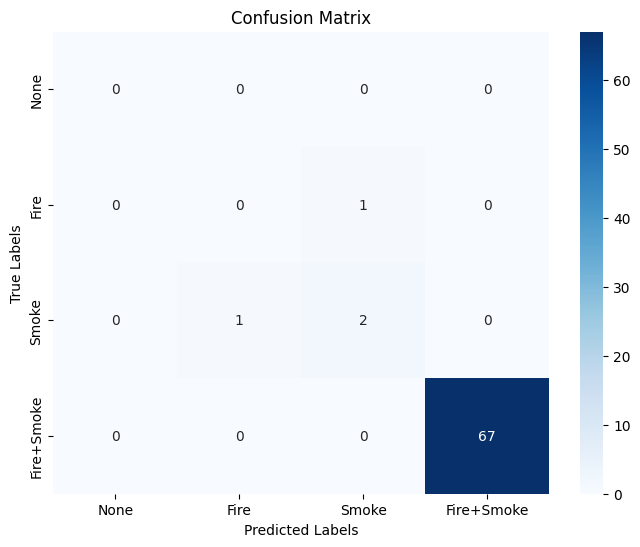

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Corrected confusion matrix
# True labels are rows, predicted labels are columns
# Assuming the order: [None, Fire, Smoke, Fire+Smoke]
conf_matrix = np.array([[0, 0, 0, 0],  # None
                        [0, 0, 1, 0],  # Fire (1 image incorrectly classified as Fire from Smoke)
                        [0, 1, 2, 0],  # Smoke (3 images: 2 correctly as Smoke, 1 incorrectly as Fire)
                        [0, 0, 0, 67]]) # Fire+Smoke (67 images correctly identified)

labels = ['None', 'Fire', 'Smoke', 'Fire+Smoke']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Description: This heatmap provides a detailed view of the confusion matrix, which shows the counts of true positives, false positives, false negatives, and true negatives for each category.



Matrix Layout:
Rows represent the actual categories.
Columns represent the predicted categories.
Diagonal elements represent correct classifications, while off-diagonal elements show misclassifications.

Rows Represent True Labels:

None: No instances of 'None' in the predictions.
Fire: There were no actual 'Fire' images, but 1 'Smoke' image was misclassified as 'Fire'.
Smoke: Two 'Smoke' images were correctly predicted, but 1 'Smoke' image was incorrectly classified as 'Fire'.
Fire+Smoke: All 67 images of 'Fire+Smoke' were correctly predicted.


Columns Represent Predicted Labels:

None: No predictions were made as 'None'.
Fire: 1 image from the 'Smoke' category was incorrectly predicted as 'Fire'.
Smoke: 2 images from the 'Smoke' category were correctly predicted as 'Smoke'; 1 image was incorrectly predicted as 'Fire'.
Fire+Smoke: 67 instances of 'Fire+Smoke' were correctly predicted.

In [28]:
''''Description: This heatmap provides a detailed view of the confusion matrix, which shows the counts of true positives, false positives, false negatives, and true negatives for each category.
Matrix Layout:
Rows represent the actual categories.
Columns represent the predicted categories.
Diagonal elements represent correct classifications, while off-diagonal elements show misclassifications.'''

"'Description: This heatmap provides a detailed view of the confusion matrix, which shows the counts of true positives, false positives, false negatives, and true negatives for each category.\nMatrix Layout:\nRows represent the actual categories.\nColumns represent the predicted categories.\nDiagonal elements represent correct classifications, while off-diagonal elements show misclassifications."

In [ ]:
#After prompt chnage, prompt engineering--shapng responses

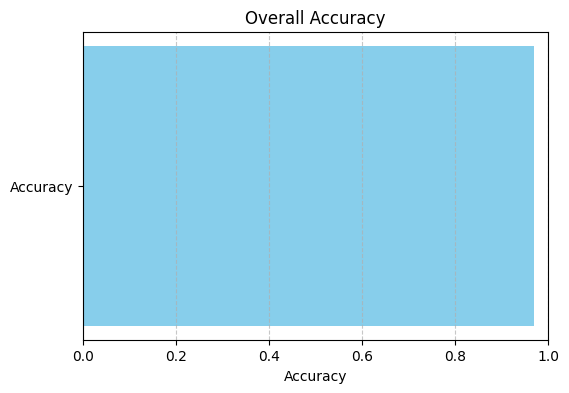

In [24]:
import matplotlib.pyplot as plt

# Overall accuracy
accuracy = 0.97

plt.figure(figsize=(6, 4))
plt.barh(['Accuracy'], [accuracy], color='skyblue')
plt.xlabel('Accuracy')
plt.xlim(0, 1)
plt.title('Overall Accuracy')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [39]:
import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part
from google.oauth2 import service_account
from io import BytesIO
from PIL import Image
import os
import shutil
import cv2
import numpy as np
from multiprocessing.pool import ThreadPool

# Initialize Vertex AI with credentials
credentials = service_account.Credentials.from_service_account_file(
    filename=r".json",
    scopes=['']
)

def image_to_base64(image_path):
    with Image.open(image_path) as img:
        buffered = BytesIO()
        img.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str

def classify_image(image_base64):
    vertexai.init(project="", location="", credentials=credentials)
    model = GenerativeModel("gemini")

    image_part = Part.from_data(
        mime_type="image/png",
        data=base64.b64decode(image_base64)
    )

    prompt = """Process the each and evry image very clearly and caccurately detect whether image consist of 'fire,' 'smoke,' or 'fire+smoke' dont give worng outcome . 
    Return only the detected keyword (fire, smoke, or fire+smoke) along with the confidence score and the bounding box coordinates indicating the region of the image where the abnormality is located."""

    responses = model.generate_content(
        [prompt, image_part],
        generation_config={
            "max_output_tokens": 8192,
            "temperature": 1,
            "top_p": 0.95,
        },
        safety_settings={},
        stream=True,
    )

    result = ""
    for response in responses:
        result += response.text

    return result.strip().lower()

def process_frame(frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir, abnormality_group_id):
    frame_resized = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)
    frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
    frame_diff = cv2.absdiff(prev_frame_gray, frame_gray)
    _, thresh = cv2.threshold(frame_diff, threshold_value, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected = any(cv2.contourArea(contour) > min_contour_area for contour in contours)
    if detected:
        output_frame_path = os.path.join(output_dir, f"abnormality_{abnormality_group_id}", f"frame_{frame_number}.jpg")
        cv2.imwrite(output_frame_path, frame_resized)
    
    return detected, frame_gray

def motion_detection(video_path, output_dir, threshold_value=25, min_contour_area=500, resize_factor=0.5, minimal_fps=5, min_abnormality_gap_minutes=1):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file")
        return

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_skip_interval = int(round(original_fps / minimal_fps))

    ret, prev_frame = cap.read()
    if not ret:
        print("Error reading the first frame")
        return

    prev_frame = cv2.resize(prev_frame, (0, 0), fx=resize_factor, fy=resize_factor)
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    abnormality_times = []

    frame_number = 0
    abnormality_detected = False
    abnormality_start_frame = None
    abnormality_group_id = 0
    last_abnormality_time = None

    os.makedirs(output_dir, exist_ok=True)

    pool = ThreadPool(processes=4)  # Use a thread pool with 4 threads

    while True:
        for _ in range(frame_skip_interval):
            ret = cap.grab()  # Use grab to skip frames efficiently
            if not ret:
                break
            frame_number += 1

        if not ret:
            break

        ret, frame = cap.retrieve()  # Retrieve the frame after skipping
        if not ret:
            break

        # Use thread pool to process frame
        result = pool.apply_async(process_frame, (frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir, abnormality_group_id))
        detected, prev_frame_gray = result.get()

        if detected:
            current_abnormality_time = frame_number / original_fps

            if not abnormality_detected:
                if last_abnormality_time is None or (current_abnormality_time - last_abnormality_time) >= (min_abnormality_gap_minutes * 60):
                    abnormality_group_id += 1
                    os.makedirs(os.path.join(output_dir, f"abnormality_{abnormality_group_id}"))

                abnormality_start_frame = frame_number
                abnormality_detected = True
                abnormality_times.append(frame_number)
                last_abnormality_time = current_abnormality_time

        else:
            if abnormality_detected:
                abnormality_detected = False
                abnormality_end_frame = frame_number
                abnormality_start_seconds = abnormality_start_frame / original_fps
                abnormality_end_seconds = abnormality_end_frame / original_fps
                abnormality_duration_seconds = abnormality_end_seconds - abnormality_start_seconds

                print(f"Abnormality {abnormality_group_id} start time: {int(abnormality_start_seconds // 60)} minutes {abnormality_start_seconds % 60:.2f} seconds")
                print(f"Abnormality {abnormality_group_id} duration: {int(abnormality_duration_seconds // 60)} minutes {abnormality_duration_seconds % 60:.2f} seconds")

    cap.release()
    pool.close()
    pool.join()

    total_time_seconds = frame_number / original_fps
    print(f"Total video time: {int(total_time_seconds // 60)} minutes {total_time_seconds % 60:.2f} seconds")

    return abnormality_times

def classify_and_store_images(output_dir):
    fire_dir = os.path.join(output_dir, 'fire')
    smoke_dir = os.path.join(output_dir, 'smoke')
    fire_smoke_dir = os.path.join(output_dir, 'fire+smoke')

    os.makedirs(fire_dir, exist_ok=True)
    os.makedirs(smoke_dir, exist_ok=True)
    os.makedirs(fire_smoke_dir, exist_ok=True)

    for folder_name in os.listdir(output_dir):
        folder_path = os.path.join(output_dir, folder_name)
        if not os.path.isdir(folder_path) or 'abnormality_' not in folder_name:
            continue
        
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            base64_str = image_to_base64(image_path)
            classification_result = classify_image(base64_str)
            
            target_folder = None
            if "fire" in classification_result:
                if "smoke" in classification_result:
                    target_folder = fire_smoke_dir
                else:
                    target_folder = fire_dir
            elif "smoke" in classification_result:
                target_folder = smoke_dir

            if target_folder:
                new_image_path = os.path.join(target_folder, image_file)
                shutil.move(image_path, new_image_path)
                print(f"Image {image_file} classified as {classification_result} and moved to {target_folder}")

# Example usage
video_path = r"C:\Users\pkathi\Desktop\my work\computervision-video\output48.mp4"
output_dir = 'C:/Users/pkathi/Desktop/my work/computervision-video/traiGeminiOP48-2.4'
abnormality_times = motion_detection(video_path, output_dir, minimal_fps=5)

if abnormality_times:
    print("Abnormality detected at frame numbers:", abnormality_times)
    classify_and_store_images(output_dir)
else:
    print("No abnormality detected in the video.")


Abnormality 1 start time: 0 minutes 45.00 seconds
Abnormality 1 duration: 0 minutes 12.00 seconds
Abnormality 1 start time: 0 minutes 57.40 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 0 minutes 57.80 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 0 minutes 58.20 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Total video time: 0 minutes 60.00 seconds
Abnormality detected at frame numbers: [1350, 1722, 1734, 1746, 1758]
Image frame_1356.jpg classified as ```json
{
 "keyword": "smoke",
 "confidence_score": 0.9999,
 "bbox": [
  289,
  438,
  493,
  777
 ]
}
``` and moved to C:/Users/pkathi/Desktop/my work/computervision-video/traiGeminiOP48-2.4\smoke
Image frame_1362.jpg classified as smoke, 0.9999, 302,75,546,129 and moved to C:/Users/pkathi/Desktop/my work/computervision-video/traiGeminiOP48-2.4\smoke
Image frame_1368.jpg classified as ```json
{
  "keyword": "smoke",
  "confidence_score": 0.95,
  "bounding_box

In [40]:
import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part
from google.oauth2 import service_account
from io import BytesIO
from PIL import Image
import os
import shutil
import cv2
import numpy as np
from multiprocessing.pool import ThreadPool

# Initialize Vertex AI with credentials
credentials = service_account.Credentials.from_service_account_file(
    filename=r".json",
    scopes=['']
)

def image_to_base64(image_path):
    with Image.open(image_path) as img:
        buffered = BytesIO()
        img.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str

def classify_image(image_base64):
    vertexai.init(project=" ", location="", credentials=credentials)
    model = GenerativeModel("gemini-1.5")

    image_part = Part.from_data(
        mime_type="image/png",
        data=base64.b64decode(image_base64)
    )

    prompt = """Process the each and evry image very clearly and caccurately detect whether image consist of 'fire,' 'smoke,' or 'fire+smoke' dont give worng outcome . 
    Return only the detected keyword (fire, smoke, or fire+smoke) along with the confidence score and the bounding box coordinates indicating the region of the image where the abnormality is located."""

    responses = model.generate_content(
        [prompt, image_part],
        generation_config={
            "max_output_tokens": 8192,
            "temperature": 1,
            "top_p": 0.95,
        },
        safety_settings={},
        stream=True,
    )

    result = ""
    for response in responses:
        result += response.text

    return result.strip().lower()

def process_frame(frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir, abnormality_group_id):
    frame_resized = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)
    frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
    frame_diff = cv2.absdiff(prev_frame_gray, frame_gray)
    _, thresh = cv2.threshold(frame_diff, threshold_value, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected = any(cv2.contourArea(contour) > min_contour_area for contour in contours)
    if detected:
        output_frame_path = os.path.join(output_dir, f"abnormality_{abnormality_group_id}", f"frame_{frame_number}.jpg")
        cv2.imwrite(output_frame_path, frame_resized)
    
    return detected, frame_gray

def motion_detection(video_path, output_dir, threshold_value=25, min_contour_area=500, resize_factor=0.5, minimal_fps=5, min_abnormality_gap_minutes=1):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file")
        return

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_skip_interval = int(round(original_fps / minimal_fps))

    ret, prev_frame = cap.read()
    if not ret:
        print("Error reading the first frame")
        return

    prev_frame = cv2.resize(prev_frame, (0, 0), fx=resize_factor, fy=resize_factor)
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    abnormality_times = []

    frame_number = 0
    abnormality_detected = False
    abnormality_start_frame = None
    abnormality_group_id = 0
    last_abnormality_time = None

    os.makedirs(output_dir, exist_ok=True)

    pool = ThreadPool(processes=4)  # Use a thread pool with 4 threads

    while True:
        for _ in range(frame_skip_interval):
            ret = cap.grab()  # Use grab to skip frames efficiently
            if not ret:
                break
            frame_number += 1

        if not ret:
            break

        ret, frame = cap.retrieve()  # Retrieve the frame after skipping
        if not ret:
            break

        # Use thread pool to process frame
        result = pool.apply_async(process_frame, (frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir, abnormality_group_id))
        detected, prev_frame_gray = result.get()

        if detected:
            current_abnormality_time = frame_number / original_fps

            if not abnormality_detected:
                if last_abnormality_time is None or (current_abnormality_time - last_abnormality_time) >= (min_abnormality_gap_minutes * 60):
                    abnormality_group_id += 1
                    os.makedirs(os.path.join(output_dir, f"abnormality_{abnormality_group_id}"))

                abnormality_start_frame = frame_number
                abnormality_detected = True
                abnormality_times.append(frame_number)
                last_abnormality_time = current_abnormality_time

        else:
            if abnormality_detected:
                abnormality_detected = False
                abnormality_end_frame = frame_number
                abnormality_start_seconds = abnormality_start_frame / original_fps
                abnormality_end_seconds = abnormality_end_frame / original_fps
                abnormality_duration_seconds = abnormality_end_seconds - abnormality_start_seconds

                print(f"Abnormality {abnormality_group_id} start time: {int(abnormality_start_seconds // 60)} minutes {abnormality_start_seconds % 60:.2f} seconds")
                print(f"Abnormality {abnormality_group_id} duration: {int(abnormality_duration_seconds // 60)} minutes {abnormality_duration_seconds % 60:.2f} seconds")

    cap.release()
    pool.close()
    pool.join()

    total_time_seconds = frame_number / original_fps
    print(f"Total video time: {int(total_time_seconds // 60)} minutes {total_time_seconds % 60:.2f} seconds")

    return abnormality_times

def classify_and_store_images(output_dir):
    fire_dir = os.path.join(output_dir, 'fire')
    smoke_dir = os.path.join(output_dir, 'smoke')
    fire_smoke_dir = os.path.join(output_dir, 'fire+smoke')

    os.makedirs(fire_dir, exist_ok=True)
    os.makedirs(smoke_dir, exist_ok=True)
    os.makedirs(fire_smoke_dir, exist_ok=True)

    for folder_name in os.listdir(output_dir):
        folder_path = os.path.join(output_dir, folder_name)
        if not os.path.isdir(folder_path) or 'abnormality_' not in folder_name:
            continue
        
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            base64_str = image_to_base64(image_path)
            classification_result = classify_image(base64_str)
            
            target_folder = None
            if "fire" in classification_result:
                if "smoke" in classification_result:
                    target_folder = fire_smoke_dir
                else:
                    target_folder = fire_dir
            elif "smoke" in classification_result:
                target_folder = smoke_dir

            if target_folder:
                new_image_path = os.path.join(target_folder, image_file)
                shutil.move(image_path, new_image_path)
                print(f"Image {image_file} classified as {classification_result} and moved to {target_folder}")

# Example usage
video_path = r"C:\Users\pkathi\Desktop\my work\computervision-video\C1007trimmed116-118.mp4"
output_dir = 'C:/Users/pkathi/Desktop/my work/computervision-video/traiGeminiC1007-2.4'
abnormality_times = motion_detection(video_path, output_dir, minimal_fps=5)

if abnormality_times:
    print("Abnormality detected at frame numbers:", abnormality_times)
    classify_and_store_images(output_dir)
else:
    print("No abnormality detected in the video.")


Abnormality 1 start time: 0 minutes 57.60 seconds
Abnormality 1 duration: 0 minutes 0.80 seconds
Abnormality 1 start time: 0 minutes 58.60 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 1 minutes 3.00 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 1 minutes 3.40 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 1 minutes 17.00 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 1 minutes 17.40 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Total video time: 1 minutes 60.00 seconds
Abnormality detected at frame numbers: [1728, 1758, 1890, 1902, 2310, 2322]
Image frame_1734.jpg classified as fire+smoke, 0.9999, 19,114,431,420 and moved to C:/Users/pkathi/Desktop/my work/computervision-video/traiGeminiC1007-2.4\fire+smoke
Image frame_1740.jpg classified as ```json
{
  "keyword": "fire+smoke",
  "confidence_score": 0.99,
  "bounding_box": [
    22,
    385

In [41]:
import os
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import numpy as np

def load_images_from_folder(folder):
    return set(filename for filename in os.listdir(folder) if os.path.isfile(os.path.join(folder, filename)))

def evaluate_classification(ground_truth_base, classified_base):
    categories = ['fire', 'smoke', 'fire+smoke']
    
    # Initialize lists to store ground truth and predictions
    y_true = []
    y_pred = []

    # Track false positives and false negatives
    false_positives = {category: set() for category in categories}
    false_negatives = {category: set() for category in categories}

    for category in categories:
        gt_folder = os.path.join(ground_truth_base, category)
        classified_folder = os.path.join(classified_base, category)

        gt_images = load_images_from_folder(gt_folder)
        classified_images = load_images_from_folder(classified_folder)

        # Compare classified images to ground truth
        for image in classified_images:
            if image in gt_images:
                y_true.append(category)
                y_pred.append(category)
            else:
                y_true.append('none')
                y_pred.append(category)
                false_positives[category].add(image)
        
        # Find false negatives
        for image in gt_images:
            if image not in classified_images:
                y_true.append(category)
                y_pred.append('none')
                false_negatives[category].add(image)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=categories + ['none'], average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=categories + ['none'])

    print(f"Overall Accuracy: {accuracy:.2f}")
    
    for i, category in enumerate(categories):
        print(f"\nCategory: {category}")
        print(f"Precision: {precision[i]:.2f}")
        print(f"Recall: {recall[i]:.2f}")
        print(f"F1 Score: {f1[i]:.2f}")
        print(f"False Positives: {len(false_positives[category])}")
        print(f"False Negatives: {len(false_negatives[category])}")
    
    print("\nConfusion Matrix:")
    print("Rows represent the true categories, columns represent the predicted categories.")
    print(np.array(categories + ['none']))
    print(conf_matrix)

# Define paths
ground_truth_base = r'C:\Users\pkathi\Desktop\my work\computervision-video\Evaluation'
classified_base = r"C:\Users\pkathi\Desktop\my work\computervision-video\traiGeminiOP48-2.4\EvaluationClassification2"

evaluate_classification(ground_truth_base, classified_base)

Overall Accuracy: 1.00

Category: fire
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
False Positives: 0
False Negatives: 0

Category: smoke
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
False Positives: 0
False Negatives: 0

Category: fire+smoke
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
False Positives: 0
False Negatives: 0

Confusion Matrix:
Rows represent the true categories, columns represent the predicted categories.
['fire' 'smoke' 'fire+smoke' 'none']
[[ 0  0  0  0]
 [ 0  3  0  0]
 [ 0  0 67  0]
 [ 0  0  0  0]]


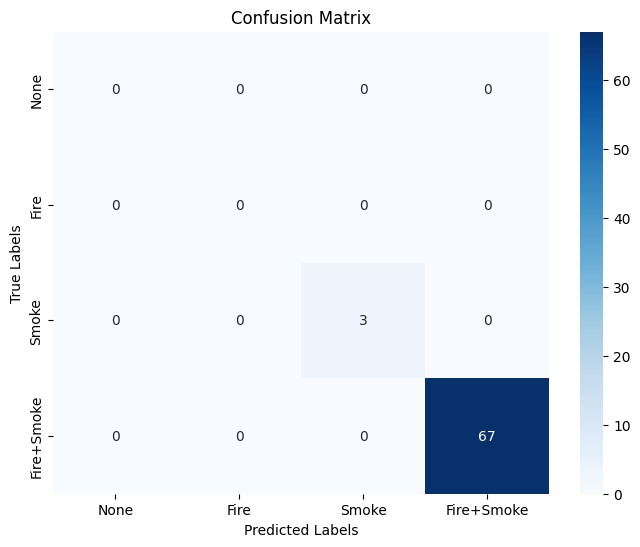

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Corrected confusion matrix
# True labels are rows, predicted labels are columns
# Assuming the order: [None, Fire, Smoke, Fire+Smoke]
conf_matrix = np.array([[ 0 , 0 , 0 , 0],
                        [ 0 , 0,  0 , 0],
                        [ 0 , 0, 3  ,0],
                        [ 0 , 0  ,0, 67]]) # Fire+Smoke (67 images correctly identified)

labels = ['None', 'Fire', 'Smoke', 'Fire+Smoke']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


C:\Users\pkathi\AppData\Local\Temp\ipykernel_22360\3491267511.py:14: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
C:\Users\pkathi\AppData\Local\Temp\ipykernel_22360\3491267511.py:15: RuntimeWarning: invalid value encountered in divide
  recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)


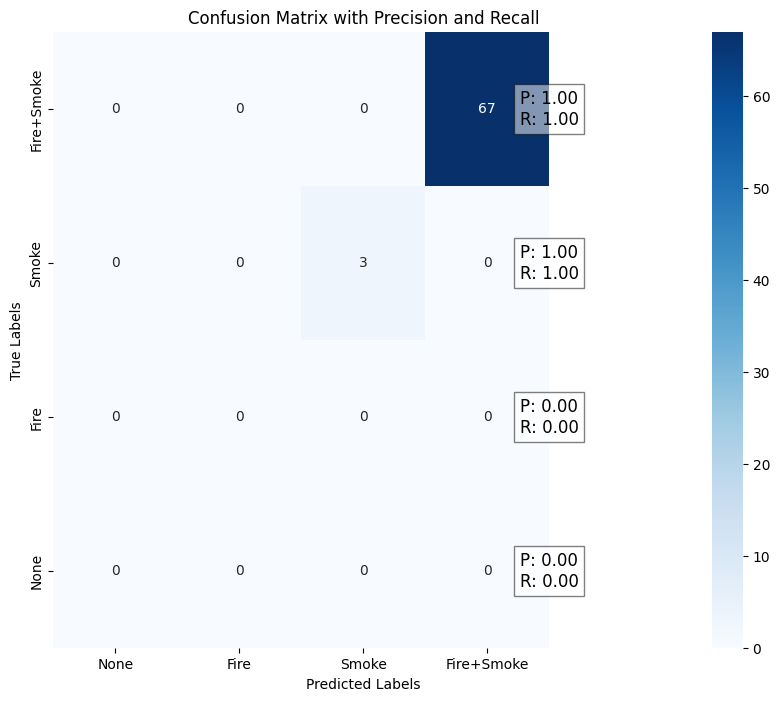

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix (True labels are rows, predicted labels are columns)
conf_matrix = np.array([[ 0 , 0 , 0 , 0],
                        [ 0 , 0,  0 , 0],
                        [ 0 , 0, 3  ,0],
                        [ 0 , 0  ,0, 67]]) # Fire+Smoke (67 images correctly identified)

labels = ['None', 'Fire', 'Smoke', 'Fire+Smoke']

# Calculate precision and recall
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# Handle any NaN values that may result from division by zero
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)

plt.figure(figsize=(10, 8))

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Display precision and recall in the matrix
for i in range(len(labels)):
    plt.text(len(labels), i + 0.5, f'P: {precision[i]:.2f}\nR: {recall[i]:.2f}', 
             va='center', ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Adjust the plot to make room for precision/recall
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Precision and Recall')
plt.xlim([0, len(labels) + 1])
plt.ylim([0, len(labels)])
plt.show()


In [50]:
import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part
from google.oauth2 import service_account
from io import BytesIO
from PIL import Image
import os
import shutil
import cv2
import numpy as np
from multiprocessing.pool import ThreadPool

# Initialize Vertex AI with credentials
credentials = service_account.Credentials.from_service_account_file(
    filename=r" ",
    scopes=[' ']
)

def image_to_base64(image_path):
    with Image.open(image_path) as img:
        buffered = BytesIO()
        img.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str

def classify_image(image_base64):
    vertexai.init(project=" ", location=" ", credentials=credentials)
    model = GenerativeModel("gemini")

    image_part = Part.from_data(
        mime_type="image/png",
        data=base64.b64decode(image_base64)
    )

    prompt = """Process the each and evry image very clearly and accurately detect whether image consist of 'fire,' 'smoke,' or 'fire+smoke' dont give worng outcome . 
    Return only the detected keyword (fire, smoke, or fire+smoke) along with the confidence score and the bounding box coordinates indicating the region of the image where the abnormality is located."""

    responses = model.generate_content(
        [prompt, image_part],
        generation_config={
            "max_output_tokens": 8192,
            "temperature": 1,
            "top_p": 0.95,
        },
        safety_settings={},
        stream=True,
    )

    result = ""
    for response in responses:
        result += response.text

    return result.strip().lower()

def process_frame(frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir, abnormality_group_id):
    frame_resized = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)
    frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
    frame_diff = cv2.absdiff(prev_frame_gray, frame_gray)
    _, thresh = cv2.threshold(frame_diff, threshold_value, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected = any(cv2.contourArea(contour) > min_contour_area for contour in contours)
    if detected:
        output_frame_path = os.path.join(output_dir, f"abnormality_{abnormality_group_id}", f"frame_{frame_number}.jpg")
        cv2.imwrite(output_frame_path, frame_resized)
    
    return detected, frame_gray

def motion_detection(video_path, output_dir, threshold_value=25, min_contour_area=500, resize_factor=0.5, minimal_fps=5, min_abnormality_gap_minutes=1):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file")
        return

    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_skip_interval = int(round(original_fps / minimal_fps))

    ret, prev_frame = cap.read()
    if not ret:
        print("Error reading the first frame")
        return

    prev_frame = cv2.resize(prev_frame, (0, 0), fx=resize_factor, fy=resize_factor)
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    abnormality_times = []

    frame_number = 0
    abnormality_detected = False
    abnormality_start_frame = None
    abnormality_group_id = 0
    last_abnormality_time = None

    os.makedirs(output_dir, exist_ok=True)

    pool = ThreadPool(processes=4)  # Use a thread pool with 4 threads

    while True:
        for _ in range(frame_skip_interval):
            ret = cap.grab()  # Use grab to skip frames efficiently
            if not ret:
                break
            frame_number += 1

        if not ret:
            break

        ret, frame = cap.retrieve()  # Retrieve the frame after skipping
        if not ret:
            break

        # Use thread pool to process frame
        result = pool.apply_async(process_frame, (frame, prev_frame_gray, threshold_value, min_contour_area, original_fps, frame_number, resize_factor, output_dir, abnormality_group_id))
        detected, prev_frame_gray = result.get()

        if detected:
            current_abnormality_time = frame_number / original_fps

            if not abnormality_detected:
                if last_abnormality_time is None or (current_abnormality_time - last_abnormality_time) >= (min_abnormality_gap_minutes * 60):
                    abnormality_group_id += 1
                    os.makedirs(os.path.join(output_dir, f"abnormality_{abnormality_group_id}"))

                abnormality_start_frame = frame_number
                abnormality_detected = True
                abnormality_times.append(frame_number)
                last_abnormality_time = current_abnormality_time

        else:
            if abnormality_detected:
                abnormality_detected = False
                abnormality_end_frame = frame_number
                abnormality_start_seconds = abnormality_start_frame / original_fps
                abnormality_end_seconds = abnormality_end_frame / original_fps
                abnormality_duration_seconds = abnormality_end_seconds - abnormality_start_seconds

                print(f"Abnormality {abnormality_group_id} start time: {int(abnormality_start_seconds // 60)} minutes {abnormality_start_seconds % 60:.2f} seconds")
                print(f"Abnormality {abnormality_group_id} duration: {int(abnormality_duration_seconds // 60)} minutes {abnormality_duration_seconds % 60:.2f} seconds")

    cap.release()
    pool.close()
    pool.join()

    total_time_seconds = frame_number / original_fps
    print(f"Total video time: {int(total_time_seconds // 60)} minutes {total_time_seconds % 60:.2f} seconds")

    return abnormality_times

def classify_and_store_images(output_dir):
    fire_dir = os.path.join(output_dir, 'fire')
    smoke_dir = os.path.join(output_dir, 'smoke')

    os.makedirs(fire_dir, exist_ok=True)
    os.makedirs(smoke_dir, exist_ok=True)

    for folder_name in os.listdir(output_dir):
        folder_path = os.path.join(output_dir, folder_name)
        if not os.path.isdir(folder_path) or 'abnormality_' not in folder_name:
            continue
        
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            base64_str = image_to_base64(image_path)
            classification_result = classify_image(base64_str)
            
            target_folder = None
            if "fire" in classification_result:
                # Move "fire+smoke" to the fire folder
                target_folder = fire_dir
            elif "smoke" in classification_result:
                target_folder = smoke_dir

            if target_folder:
                new_image_path = os.path.join(target_folder, image_file)
                shutil.move(image_path, new_image_path)
                print(f"Image {image_file} classified as {classification_result} and moved to {target_folder}")

# Example usage
video_path = r"C:\Users\pkathi\Desktop\my work\computervision-video\output48.mp4"
output_dir = 'C:/Users/pkathi/Desktop/my work/computervision-video/traiGeminiOP48-2.6'
abnormality_times = motion_detection(video_path, output_dir, minimal_fps=5)

if abnormality_times:
    print("Abnormality detected at frame numbers:", abnormality_times)
    classify_and_store_images(output_dir)
else:
    print("No abnormality detected in the video.")

Abnormality 1 start time: 0 minutes 45.00 seconds
Abnormality 1 duration: 0 minutes 12.00 seconds
Abnormality 1 start time: 0 minutes 57.40 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 0 minutes 57.80 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Abnormality 1 start time: 0 minutes 58.20 seconds
Abnormality 1 duration: 0 minutes 0.20 seconds
Total video time: 0 minutes 60.00 seconds
Abnormality detected at frame numbers: [1350, 1722, 1734, 1746, 1758]
Image frame_1362.jpg classified as smoke, 0.9994, 333,252,765,894 and moved to C:/Users/pkathi/Desktop/my work/computervision-video/traiGeminiOP48-2.6\smoke
Image frame_1368.jpg classified as ```json
{
  "keyword": "smoke",
  "confidence_score": 0.99,
  "bounding_box": [
    555,
    292,
    819,
    481
  ]
}
``` and moved to C:/Users/pkathi/Desktop/my work/computervision-video/traiGeminiOP48-2.6\smoke
Image frame_1374.jpg classified as fire+smoke, 0.98, 594 418 768 519 and moved to C:/Users/

In [48]:
import os
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import numpy as np

def load_images_from_folder(folder):
    return set(filename for filename in os.listdir(folder) if os.path.isfile(os.path.join(folder, filename)))

def evaluate_classification(ground_truth_base, classified_base):
    categories = ['fire', 'smoke']
    
    # Initialize lists to store ground truth and predictions
    y_true = []
    y_pred = []

    # Track false positives and false negatives
    false_positives = {category: set() for category in categories}
    false_negatives = {category: set() for category in categories}

    for category in categories:
        gt_folder = os.path.join(ground_truth_base, category)
        classified_folder = os.path.join(classified_base, category)

        gt_images = load_images_from_folder(gt_folder)
        classified_images = load_images_from_folder(classified_folder)

        # Compare classified images to ground truth
        for image in classified_images:
            if image in gt_images:
                y_true.append(category)
                y_pred.append(category)
            else:
                y_true.append('none')
                y_pred.append(category)
                false_positives[category].add(image)
        
        # Find false negatives
        for image in gt_images:
            if image not in classified_images:
                y_true.append(category)
                y_pred.append('none')
                false_negatives[category].add(image)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=categories + ['none'], average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=categories + ['none'])

    print(f"Overall Accuracy: {accuracy:.2f}")
    
    for i, category in enumerate(categories):
        print(f"\nCategory: {category}")
        print(f"Precision: {precision[i]:.2f}")
        print(f"Recall: {recall[i]:.2f}")
        print(f"F1 Score: {f1[i]:.2f}")
        print(f"False Positives: {len(false_positives[category])}")
        print(f"False Negatives: {len(false_negatives[category])}")
    
    print("\nConfusion Matrix:")
    print("Rows represent the true categories, columns represent the predicted categories.")
    print(np.array(categories + ['none']))
    print(conf_matrix)

# Define paths
ground_truth_base = r"C:\Users\pkathi\Desktop\my work\computervision-video\traiGeminiOP48-2.5\Evaluation"
classified_base = r"C:\Users\pkathi\Desktop\my work\computervision-video\traiGeminiOP48-2.3\Evaluation-classified"

evaluate_classification(ground_truth_base, classified_base)


Overall Accuracy: 0.03

Category: fire
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
False Positives: 1
False Negatives: 67

Category: smoke
Precision: 1.00
Recall: 0.67
F1 Score: 0.80
False Positives: 0
False Negatives: 1

Confusion Matrix:
Rows represent the true categories, columns represent the predicted categories.
['fire' 'smoke' 'none']
[[ 0  0 67]
 [ 0  2  1]
 [ 1  0  0]]
